1. 2D kernel density estimator

In [1]:
import numpy as np
bq_data = np.loadtxt('BQmat_orig.txt', delimiter=',')

<IPython.core.display.Javascript object>


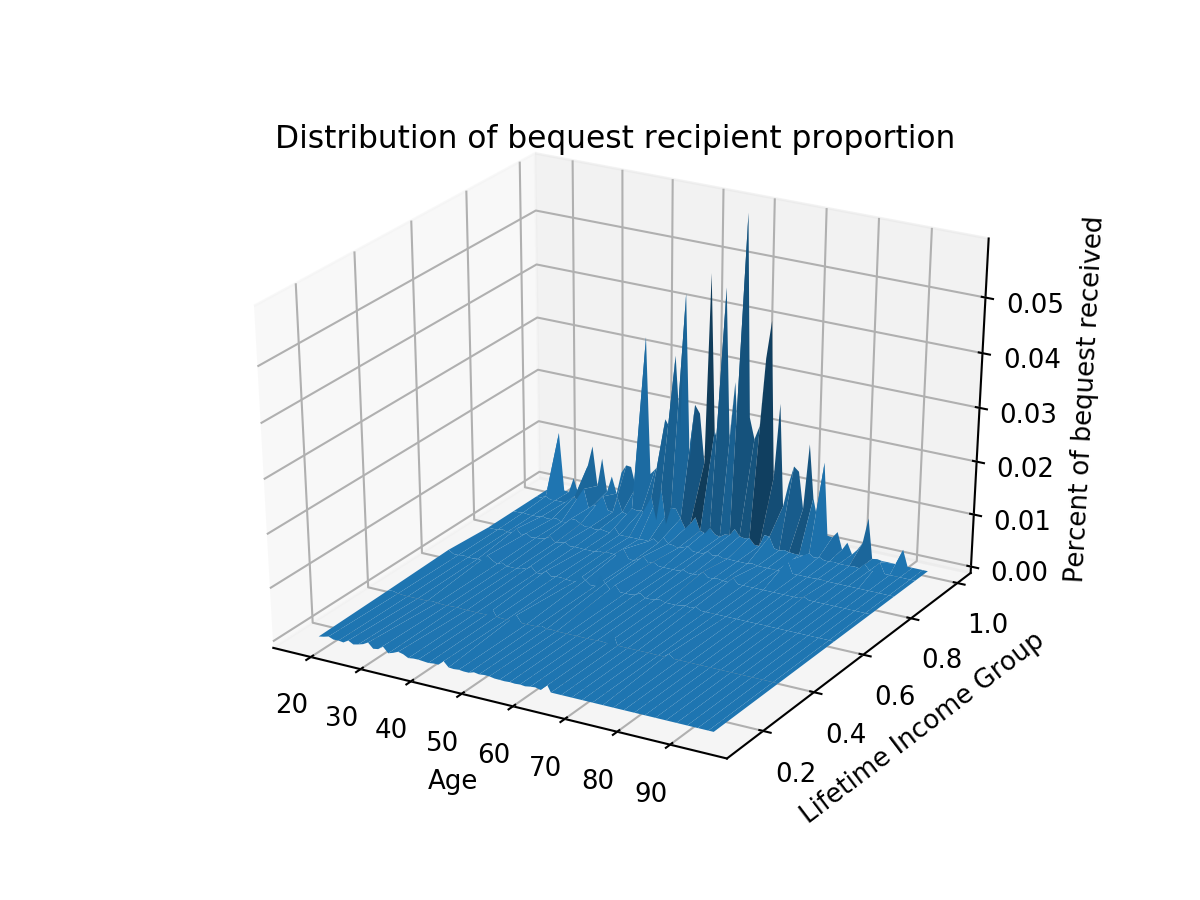

In [19]:
# (a)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

ages_vec = np.arange(18, 96)
abils = np.array([0.25, 0.25, 0.20, 0.10, 0.10, 0.09, 0.01])
abils_mdpts = np.array([0.125, 0.375, 0.60, 0.75, 0.85, 0.94, 0.995])
abils_mat, ages_mat = np.meshgrid(abils_mdpts, ages_vec)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(ages_mat, abils_mat, bq_data)
ax.set_title('Distribution of bequest recipient proportion')
ax.set_xlabel('Age')
ax.set_ylabel('Lifetime Income Group')
ax.set_zlabel('Percent of bequest received')
plt.show()

In [3]:
# (b)
from scipy.stats import gaussian_kde

def get_scaled(bandwidth):
    prop_mat_inc = np.sum(bq_data, axis=0)
    prop_mat_age = np.sum(bq_data, axis=1)
    lrg_samp = 70000

    age_probs = np.random.multinomial(lrg_samp, prop_mat_age)
    income_probs = np.random.multinomial(lrg_samp, prop_mat_inc)
    age_freq = np.array([])
    inc_freq = np.array([])

    for age, num_s in zip(ages_vec, age_probs):
        vec_age_s = np.ones(num_s)
        vec_age_s *= age
        age_freq = np.append(age_freq, vec_age_s)

    for abil, num_j in zip(abils_mdpts, income_probs):
        vec_abil_j = np.ones(num_j)
        vec_abil_j *= abil
        inc_freq = np.append(inc_freq, vec_abil_j)

    data = np.vstack((age_freq, inc_freq))
    density = gaussian_kde(data, bw_method = bandwidth)

    coords = np.vstack([item.ravel() for item in [ages_mat, abils_mat]])
    BQkde = density(coords).reshape(ages_mat.shape)
    BQkde_scaled = BQkde / np.sum(BQkde)
    
    return BQkde_scaled

In [4]:
def draw_scaled(data):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot_surface(ages_mat, abils_mat, data)
    ax.set_title('Scaled distribution of bequest recipient proportion')
    ax.set_xlabel('Age')
    ax.set_ylabel('Lifetime Income Group')
    ax.set_zlabel('Scaled percent of bequest received')
    plt.show()

<IPython.core.display.Javascript object>


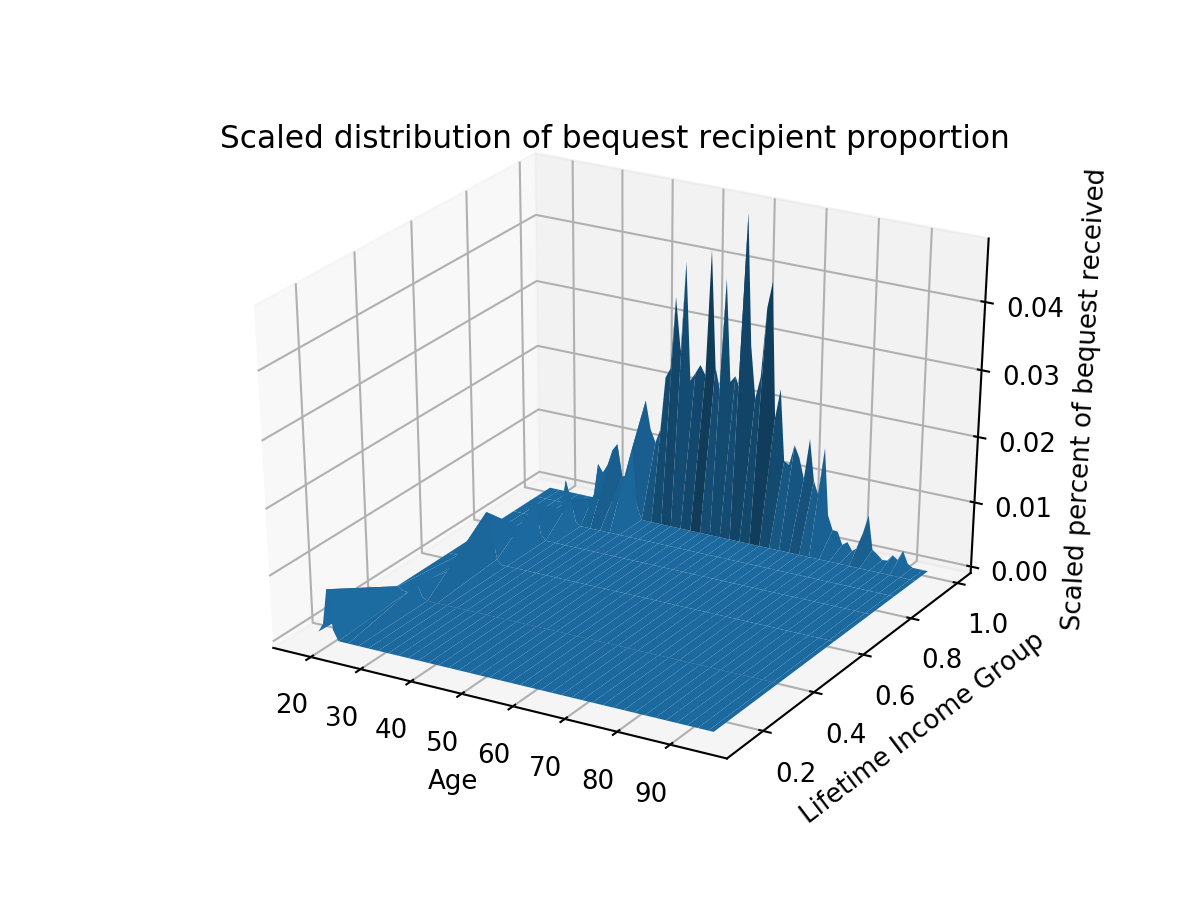

<IPython.core.display.Javascript object>


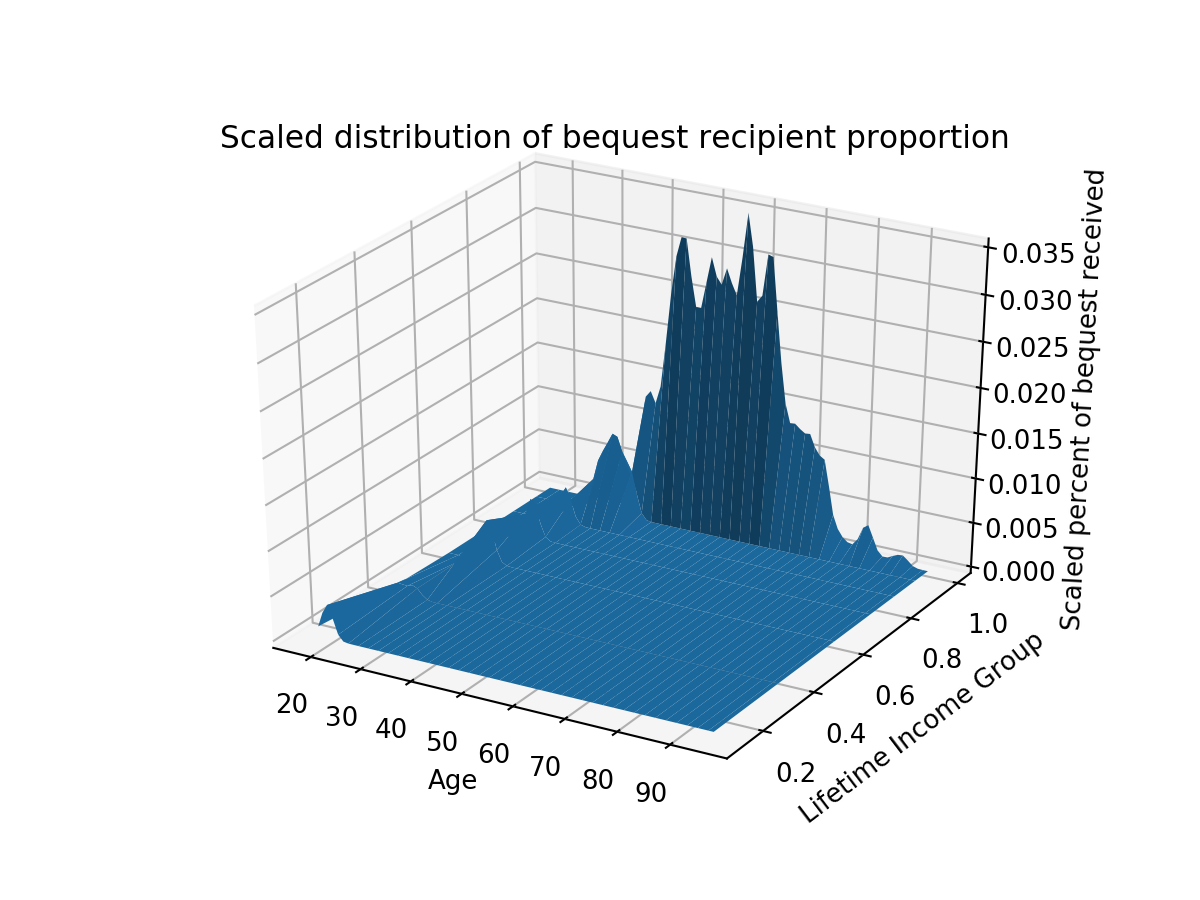

<IPython.core.display.Javascript object>


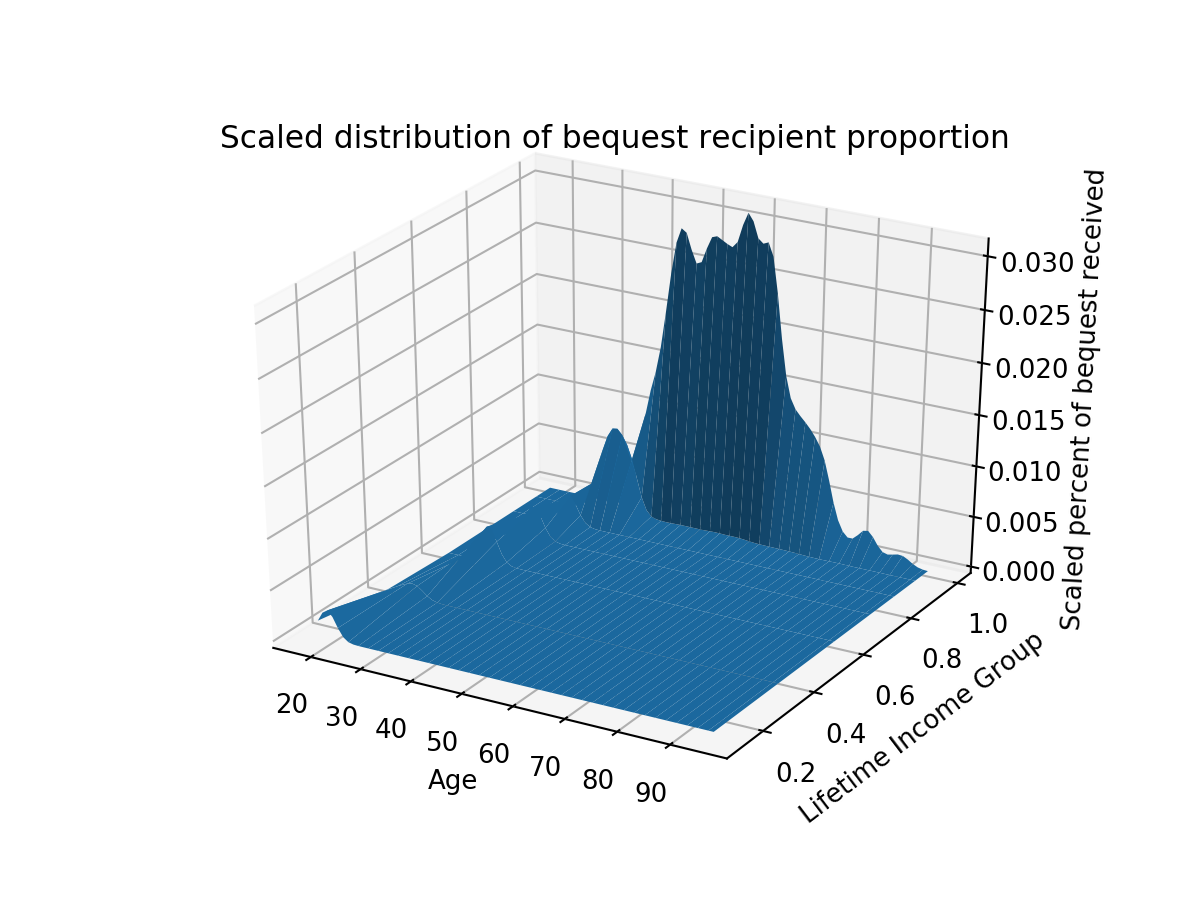

<IPython.core.display.Javascript object>


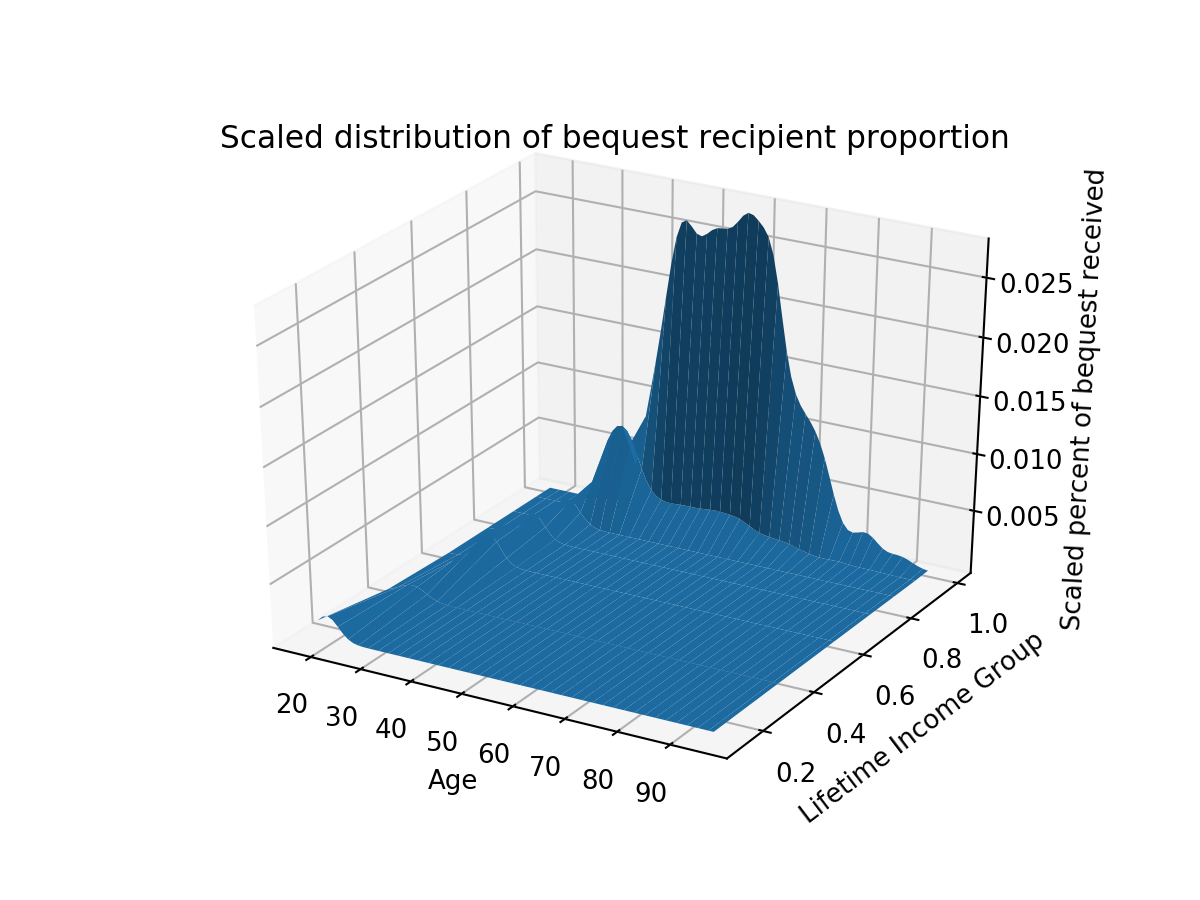

In [20]:
for bandwidth in np.arange(0.05, 0.2, 0.05):
    draw_scaled(get_scaled(bandwidth))

I will choose the bandwidth parameter as 0.1, as it reserves the unique pattern within each age group, and also it smooths the noise to some extent. The result is shown as below:

<IPython.core.display.Javascript object>


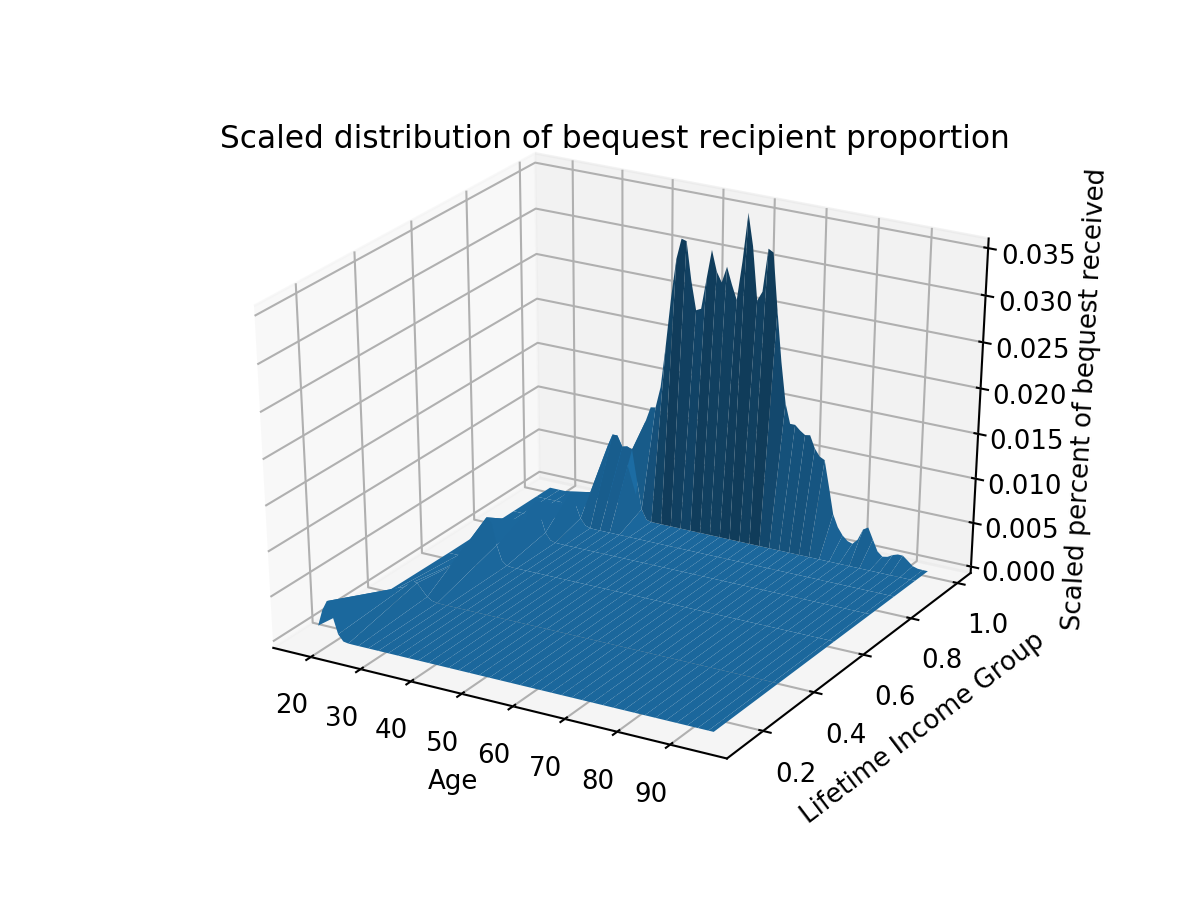

In [21]:
draw_scaled(get_scaled(0.1))

In [8]:
BQkde_scaled = get_scaled(0.1)
print('The estimated density for bequest recipients who are age 61 in the 6th lifetime income category\
is', BQkde_scaled[43][6])

The estimated density for bequest recipients who are age 61 in the 6th lifetime income categoryis 0.02694170699636351


2. Interaction terms

In [9]:
import pandas as pd

biden = pd.read_csv('biden.csv')
biden.dropna(inplace=True)
biden.head()

,biden,female,age,educ,dem,rep
0,90.0,0,19.0,12.0,1.0,0.0
1,70.0,1,51.0,14.0,1.0,0.0
2,60.0,0,27.0,14.0,0.0,0.0
3,50.0,1,43.0,14.0,1.0,0.0
4,60.0,1,38.0,14.0,0.0,1.0


In [10]:
from statsmodels.formula.api import ols
model = ols(formula = "biden ~ age + educ + age * educ", data = biden)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  biden   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     10.74
Date:                Mon, 30 Apr 2018   Prob (F-statistic):           5.37e-07
Time:                        10:47:37   Log-Likelihood:                -8249.3
No. Observations:                1807   AIC:                         1.651e+04
Df Residuals:                    1803   BIC:                         1.653e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.3735      9.564      4.012      0.0

In [11]:
result.cov_params()

,Intercept,age,educ,age:educ
Intercept,91.461810,-1.545276,-6.725883,0.114416
age,-1.545276,0.029067,0.114149,-0.002159
educ,-6.725883,0.114149,0.509785,-0.008739
age:educ,0.114416,-0.002159,-0.008739,0.000166


Please find the coefficient parameters and standard error of the fitted model above.

In [12]:
b1 = 0.6719
b2 = 1.6574
b3 = -0.0480
var_b1 = 0.029067
var_b2 = 0.509785
var_b3 = 0.000166
cov_13 = -0.002159
cov_12 = 0.114149
cov_23 = -0.008739

(a)

$Y = \beta_{0} + \beta_{1}age + \beta_{2}educ + \beta_{3}age*educ$

The marginal effect of age on Joe Biden thermometer rating, conditional on education = $\beta_{1} + \beta_{3}educ$, and the standard error of the marignal effect = $\sqrt{(Var(\beta_{1}) + educ^2 *Var(\beta_{3})+ 2*educ*Cov(\beta_{1}, \beta_{3}))}$

In [13]:
marginal_age = pd.DataFrame(columns = ['educ', 'mar', 'std', 't'])
marginal_age['educ'] = np.arange(0, 18)
marginal_age['mar'] = b1 + marginal_age['educ'] * b3
marginal_age['std'] = np.sqrt(var_b1 + marginal_age['educ']** 2 * var_b3 + 2 * marginal_age['educ'] * cov_13)
marginal_age['t'] = marginal_age['mar'] / marginal_age['std']

In [14]:
marginal_age

,educ,mar,std,t
0,0,0.6719,0.170490,3.940983
1,1,0.6239,0.157845,3.952615
2,2,0.5759,0.145241,3.965129
3,3,0.5279,0.132691,3.978405
4,4,0.4799,0.120212,3.992104
5,5,0.4319,0.107829,4.005432
6,6,0.3839,0.095577,4.016649
7,7,0.3359,0.083516,4.021961
8,8,0.2879,0.071743,4.012958
9,9,0.2399,0.060424,3.970309


The magnitude of the marginal effect is decreasing with the increasing of education, and direction of the marginal effect changes from positive to negative. The statistical significance of marginal effect is pretty strong according to the t value we calculated.

(b)

$Y = \beta_{0} + \beta_{1}age + \beta_{2}educ + \beta_{3}age*educ$

The marginal effect of education on Joe Biden thermometer rating, conditional on age = $\beta_{2} + \beta_{3}age$, and the standard error of the marignal effect = $\sqrt{(Var(\beta_{2}) + age^2 *Var(\beta_{3})+ 2*age*Cov(\beta_{2}, \beta_{3}))}$

In [15]:
marginal_educ = pd.DataFrame(columns = ['age', 'mar', 'std', 't'])
marginal_educ['age'] = np.arange(18, 94)
marginal_educ['mar'] = b2 + marginal_educ['age'] * b3
marginal_educ['std'] = np.sqrt(var_b2 + marginal_educ['age']** 2 * var_b3 + 2 * marginal_educ['age'] * cov_23)
marginal_educ['t'] = marginal_educ['mar'] / marginal_educ['std']

In [16]:
marginal_educ

,age,mar,std,t
0,18,0.7934,0.498964,1.590095
1,19,0.7454,0.487472,1.529113
2,20,0.6974,0.476051,1.464968
3,21,0.6494,0.464707,1.397438
4,22,0.6014,0.453446,1.326289
5,23,0.5534,0.442273,1.251265
6,24,0.5054,0.431195,1.172092
7,25,0.4574,0.420220,1.088477
8,26,0.4094,0.409357,1.000106
9,27,0.3614,0.398614,0.906642


The magnitude of the marginal effect is first decreasing, then increasing with the increasing of age, and direction of the marginal effect changes from positive to negative. The statistical significance of marginal effect is pretty strong according to the t value we calculated, when age is larger than 30.

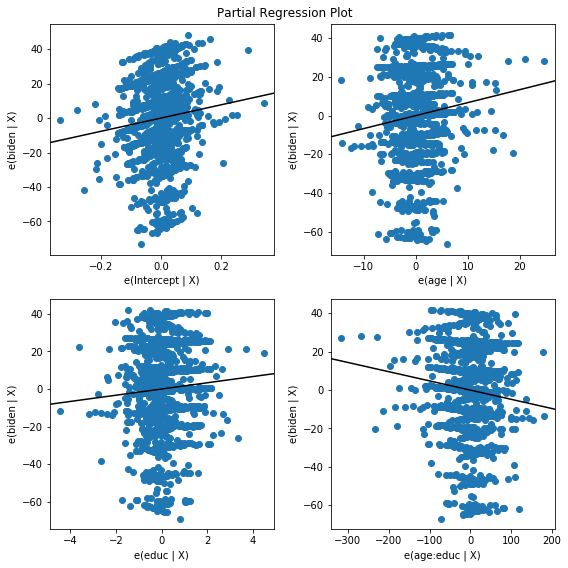

In [18]:
import statsmodels.api as sm
from pandas.core import datetools
fig = plt.figure(figsize = (8,8))
fig = sm.graphics.plot_partregress_grid(result, fig = fig)

<IPython.core.display.Javascript object>


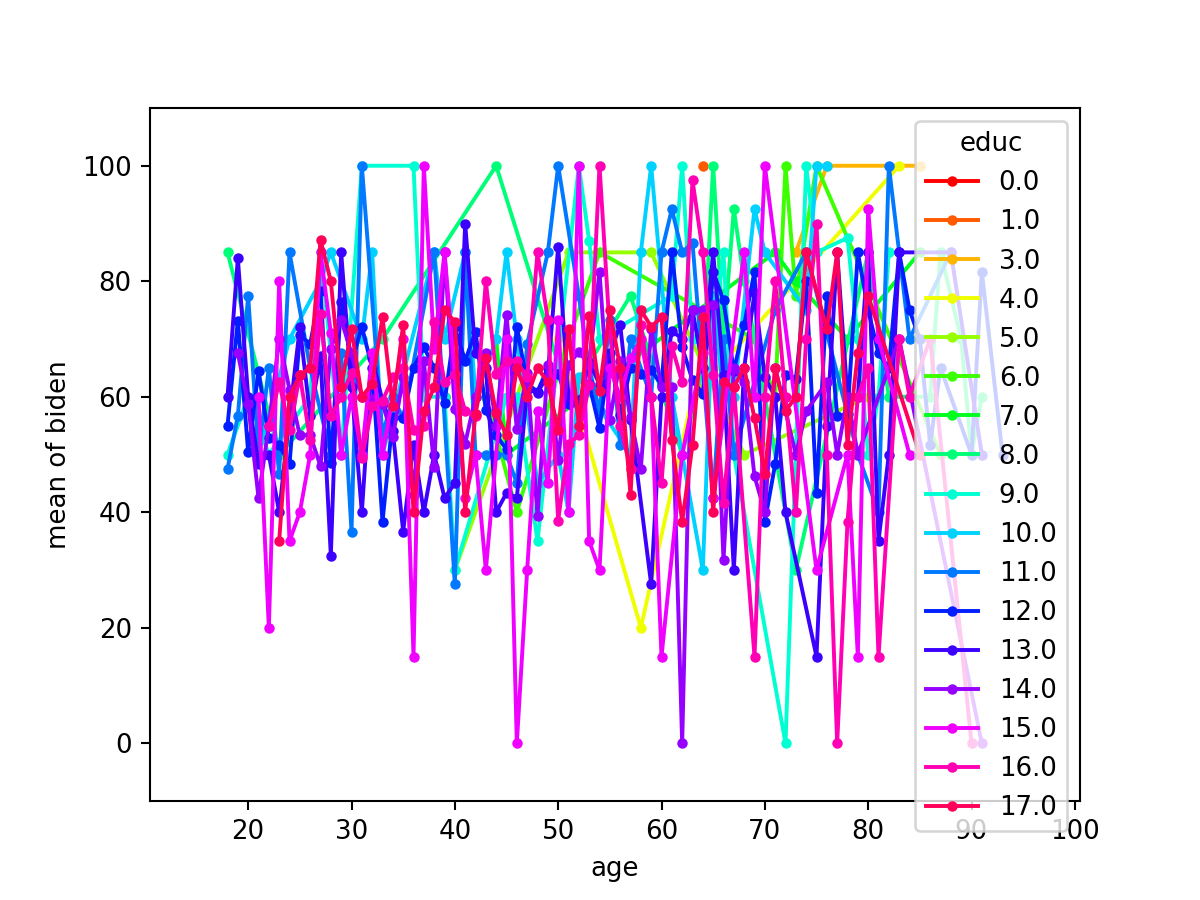

In [24]:
from statsmodels.graphics.factorplots import interaction_plot
fig = interaction_plot(biden['age'], biden['educ'], biden['biden'])

The partial regression plot and the interaction plot shown above serve as the graphical support of the answers of question 2. We can see that the interaction term is actally changing the overall pattern of regression model, and it varies with the level of age and education.